In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
!pip install -q tensorflow_datasets

You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.


In [4]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

import tensorflow_datasets as tfds

In [6]:
# 임베딩 레이어: 정수 인덱스 (특정 단어를 의미) 에서 고밀도 벡터로 매핑하는 조회 테이블로 이해
embedding_layer = layers.Embedding(1000, 5)

result = embedding_layer(tf.constant([1, 2, 3]))
result.numpy()

array([[ 0.04002221, -0.0155571 ,  0.03637798,  0.03799397, -0.03549529],
       [-0.02148186,  0.04738886,  0.00210726, -0.02441123, -0.03175862],
       [-0.01682048, -0.03860419, -0.02532327, -0.00232217,  0.04415916]],
      dtype=float32)

In [7]:
(train_data, test_data), info = tfds.load(
    'imdb_reviews/subwords8k', 
    split = (tfds.Split.TRAIN, tfds.Split.TEST), 
    with_info=True, as_supervised=True)

Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/subwords8k/1.0.0.incomplete7B5FWU/imdb_reviews-train.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/subwords8k/1.0.0.incomplete7B5FWU/imdb_reviews-test.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/subwords8k/1.0.0.incomplete7B5FWU/imdb_reviews-unsupervised.tfrecord


Dataset imdb_reviews downloaded and prepared to /root/tensorflow_datasets/imdb_reviews/subwords8k/1.0.0. Subsequent calls will reuse this data.


In [8]:
encoder = info.features['text'].encoder
encoder.subwords[:20]

['the_',
 ', ',
 '. ',
 'a_',
 'and_',
 'of_',
 'to_',
 's_',
 'is_',
 'br',
 'in_',
 'I_',
 'that_',
 'this_',
 'it_',
 ' /><',
 ' />',
 'was_',
 'The_',
 'as_']

In [9]:
train_batches = train_data.shuffle(1000).padded_batch(10)
test_batches = test_data.shuffle(1000).padded_batch(10)

In [10]:
train_batch, train_labels = next(iter(train_batches))
train_batch.numpy()

array([[  62,    9,   82, ...,    0,    0,    0],
       [3294, 1661, 4545, ...,    0,    0,    0],
       [  12,   31,   93, ...,    0,    0,    0],
       ...,
       [ 156, 5053,  113, ...,    0,    0,    0],
       [  19, 6918,   38, ...,   82, 3104, 7975],
       [ 147,   82, 1622, ...,    0,    0,    0]])

In [11]:
embedding_dim=16

model = keras.Sequential([
  layers.Embedding(encoder.vocab_size, embedding_dim),
  layers.GlobalAveragePooling1D(),
  layers.Dense(16, activation='relu'),
  layers.Dense(1)
])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 16)          130960    
_________________________________________________________________
global_average_pooling1d (Gl (None, 16)                0         
_________________________________________________________________
dense (Dense)                (None, 16)                272       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 17        
Total params: 131,249
Trainable params: 131,249
Non-trainable params: 0
_________________________________________________________________


In [12]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

history = model.fit(
    train_batches,
    epochs=10,
    validation_data=test_batches, validation_steps=20)

Epoch 1/10
2500/2500 [==============================] - 7s 3ms/step - loss: 0.5113 - accuracy: 0.6916 - val_loss: 0.3325 - val_accuracy: 0.8850
Epoch 2/10
2500/2500 [==============================] - 7s 3ms/step - loss: 0.2884 - accuracy: 0.8830 - val_loss: 0.3811 - val_accuracy: 0.8100
Epoch 3/10
2500/2500 [==============================] - 7s 3ms/step - loss: 0.2335 - accuracy: 0.9090 - val_loss: 0.4203 - val_accuracy: 0.8650
Epoch 4/10
2500/2500 [==============================] - 7s 3ms/step - loss: 0.1996 - accuracy: 0.9240 - val_loss: 0.4289 - val_accuracy: 0.8150
Epoch 5/10
2500/2500 [==============================] - 7s 3ms/step - loss: 0.1781 - accuracy: 0.9335 - val_loss: 0.3720 - val_accuracy: 0.8700
Epoch 6/10
2500/2500 [==============================] - 7s 3ms/step - loss: 0.1604 - accuracy: 0.9409 - val_loss: 0.5310 - val_accuracy: 0.8050
Epoch 7/10
2500/2500 [==============================] - 7s 3ms/step - loss: 0.1432 - accuracy: 0.9482 - val_loss: 0.4793 - val_accuracy:

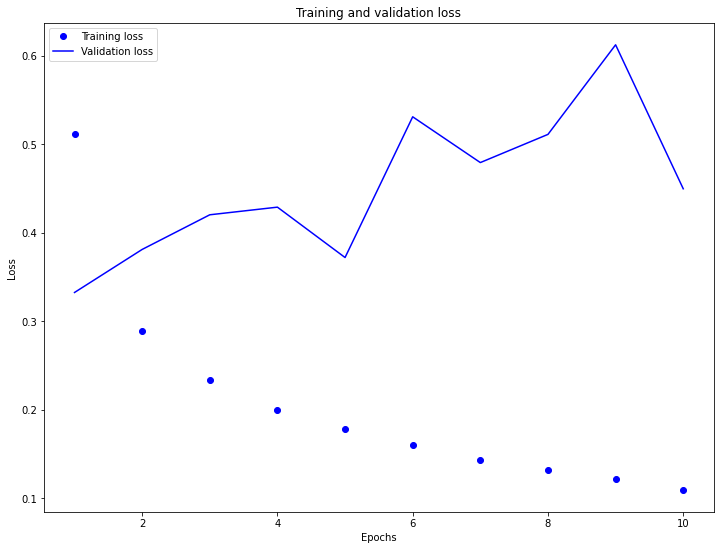

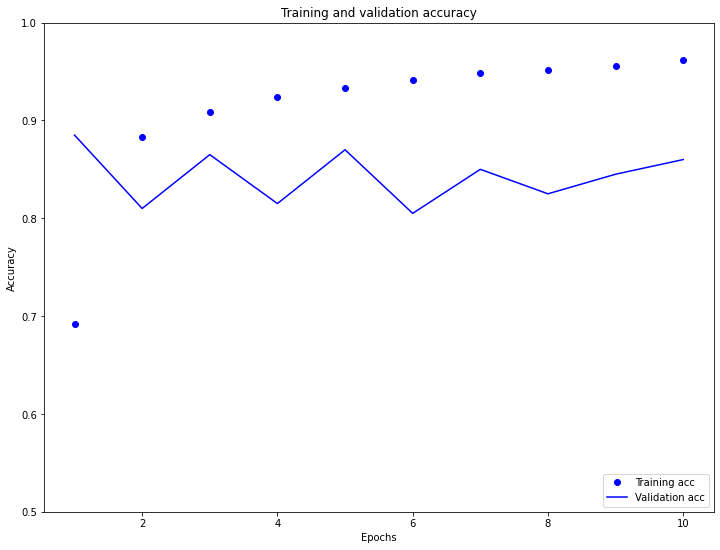

In [13]:
import matplotlib.pyplot as plt

history_dict = history.history

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss=history_dict['loss']
val_loss=history_dict['val_loss']

epochs = range(1, len(acc) + 1)

plt.figure(figsize=(12,9))
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.figure(figsize=(12,9))
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.ylim((0.5,1))
plt.show()

In [14]:
e = model.layers[0]
weights = e.get_weights()[0]
print(weights.shape) # shape: (vocab_size, embedding_dim)

(8185, 16)


In [15]:
import io

encoder = info.features['text'].encoder

out_v = io.open('vecs.tsv', 'w', encoding='utf-8')
out_m = io.open('meta.tsv', 'w', encoding='utf-8')

for num, word in enumerate(encoder.subwords):
    vec = weights[num+1] # skip 0, it's padding.
    out_m.write(word + "\n")
    out_v.write('\t'.join([str(x) for x in vec]) + "\n")
out_v.close()
out_m.close()

In [16]:
try:
    from google.colab import files
except ImportError:
    pass
else:
    files.download('vecs.tsv')
    files.download('meta.tsv')